<img src="https://sites.google.com/a/pythonpredictions.com/wiki/_/rsrc/1484769080787/home/pythongrey%20large.png?height=58&width=200" height="150" width="150" align="right">
# COBRA 1.0 as a Python library
----------------------------------------------------------------------------------------------------------
**Autor**: Jan Benisek

**Date**: 21/02/2018

**Purpose**: Show transformed COBRA 1.0 code into Python library for easy use

**Requirements**: Python 3.6 (Conda distribution), COBRA library (to be specified)

----------------------------------------------------------------------------------------------------------

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#####################
import cobra.cobra as c
#####################

data_path = 'C:/Local/pers/Documents/GitHub/COBRA/datasets/data.csv'
data_types_path = 'C:/Local/pers/Documents/GitHub/COBRA/datasets/data_types.csv'

## <font color='blue'>Data transformation</font>
The first step is, as in the original version, to import and process the data.

In [2]:
build = c.COBRA(data_path,
                data_types_path,
                partition_train=0.6,
                partition_select=0.3,
                partition_valid=0.1,
                sampling_1=1,
                sampling_0=1,
                discret_nbins=5,
                regroup_sign=0.001)
df_transformed = build.transform()

Below you can see first 10 rows of the transformed dataframe.

In [3]:
df_transformed.head(n=10)

,ID,TARGET,PARTITION,B_age,B_fnlwgt,B_education-num,B_capital-gain,B_capital-loss,B_hours-per-week,B_scont_1,B_scont_2,B_scont_3,B_scont_4,B_scont_5,B_scont_6,B_scont_7,B_scont_8,B_scont_9,B_scont_10,B_sflag_1,B_sflag_2,B_sflag_3,B_sflag_4,B_sflag_5,B_native-country,...,D_sex,D_scont_8,D_fnlwgt,D_scont_5,D_age,D_race,D_education,D_workclass,D_scat_5,D_scat_3,D_capital-gain,D_scont_9,D_education-num,D_scont_7,D_occupation,D_sflag_2,D_hours-per-week,D_scont_3,D_relationship,D_marital-status,D_scat_4,D_sflag_3,D_native-country,D_capital-loss,D_scont_2
0,22124,1,train,"(26, 33]","(196286, 259840]","(10, 13]","[..., 2174]","[..., 271]","(35, 40]","(3, 4]","(8,...]","(12,...]","(12, 16]","[..., 5]","(24,...]","(14, 22]","(24, 32]","(9, 18]","(30, 40]",0,0,1,0,1,Non-significants,...,0.304047,0.238219,0.224876,0.232523,0.182006,0.254101,0.414244,0.217757,0.239303,0.239303,0.204260,0.248669,0.365677,0.241286,0.267330,0.235206,0.208244,0.229257,0.448198,0.445326,0.239303,0.243365,0.243793,0.226442,0.253251
1,2206,1,train,"(41, 51]","(196286, 259840]","[..., 9]","[..., 2174]","[..., 271]","(35, 40]","(2, 3]","(2, 4]","[..., 3]","(4, 8]","[..., 5]","[..., 7]","[..., 7]","[..., 9]","[..., 9]","[..., 10]",0,0,1,1,1,Non-significants,...,0.107649,0.238876,0.224876,0.232523,0.389707,0.122776,0.155570,0.217757,0.239303,0.239303,0.204260,0.231891,0.126662,0.228717,0.117027,0.235206,0.208244,0.243697,0.463188,0.445326,0.239303,0.243365,0.243793,0.226442,0.233835
2,4906,1,train,"(41, 51]","(106014, 157881]","[..., 9]","[..., 2174]","[..., 271]","(35, 40]","[..., 2]","(2, 4]","[..., 3]","(4, 8]","[..., 5]","[..., 7]","[..., 7]","(32,...]","(9, 18]","(10, 20]",0,1,1,0,0,Non-significants,...,0.107649,0.240567,0.253925,0.232523,0.389707,0.254101,0.155570,0.217757,0.239303,0.239303,0.204260,0.248669,0.126662,0.228717,0.479870,0.243465,0.208244,0.243697,0.463188,0.445326,0.239303,0.243365,0.243793,0.226442,0.233835
3,13284,1,train,"(41, 51]","(259840,...]","(9, 10]","[..., 2174]","[..., 271]","(35, 40]","(4,...]","[..., 2]","[..., 3]","(12, 16]","(10, 15]","(7, 12]","(29,...]","[..., 9]","(27, 36]","(40,...]",0,0,1,1,0,Non-significants,...,0.304047,0.238876,0.234431,0.239587,0.389707,0.254101,0.189544,0.217757,0.239303,0.239303,0.204260,0.238193,0.189544,0.248608,0.267330,0.235206,0.208244,0.243697,0.448198,0.445326,0.239303,0.243365,0.243793,0.226442,0.238689
4,3369,1,train,"(33, 41]","(196286, 259840]","(13,...]","(2174,...]","[..., 271]","(50,...]","(4,...]","[..., 2]","(12,...]","(16,...]","(10, 15]","(18, 24]","(7, 14]","(9, 16]","(36,...]","(10, 20]",0,0,0,1,0,Non-significants,...,0.304047,0.240908,0.224876,0.239587,0.311346,0.254101,0.720077,0.280034,0.239303,0.239303,0.667268,0.240772,0.612475,0.241657,0.450627,0.235206,0.408981,0.229257,0.448198,0.445326,0.239303,0.235238,0.243793,0.226442,0.238689
5,10003,1,train,"(51,...]","(196286, 259840]","(9, 10]","[..., 2174]","[..., 271]","(35, 40]","(4,...]","(2, 4]","(9, 12]","(16,...]","(10, 15]","[..., 7]","[..., 7]","[..., 9]","(18, 27]","(40,...]",1,1,0,0,0,Non-significants,...,0.304047,0.238876,0.224876,0.239587,0.308136,0.254101,0.189544,0.217757,0.239303,0.239303,0.204260,0.237163,0.189544,0.228717,0.220905,0.243465,0.208244,0.243648,0.448198,0.445326,0.239303,0.235238,0.243793,0.226442,0.233835
6,3092,1,train,"(41, 51]","(259840,...]","(13,...]","[..., 2174]","(271,...]","(35, 40]","[..., 2]","(2, 4]","(6, 9]","(8, 12]","[..., 5]","(7, 12]","(7, 14]","(24, 32]","(9, 18]","(40,...]",0,1,1,0,1,Non-significants,...,0.304047,0.238219,0.234431,0.232523,0.389707,0.254101,0.720077,0.217757,0.239303,0.239303,0.204260,0.248669,0.612475,0.241657,0.297945,0.243465,0.208244,0.246056,0.448198,0.445326,0.239303,0.243365,0.243793,0.496418,0.233835
7,8705,1,train,"(41, 51]","(259840,...]","(10, 13]","[..., 2174]","[..., 271]","(35, 40]","(2, 3]","[..., 2]","(6, 9]","(4, 8]","(21,...]","(7, 12]","(22, 29]","(9, 16]","(18, 27]","(30, 40]",0,1,1,0,0,Non-significants,...,0.304047,0.240908,0.234431,0.245839,0.3897

## <font color='blue'>Univariate selection</font>
The second step in the process is univariate selection.

In [4]:
df_unisel, df_corr = build.fit_univariate(df_transformed,
                                          preselect_auc=0.53, 
                                          preselect_overtrain=5)

Below is first 10 rows of the output of univariate selection. You can see AUC on train and test and column preselection, which shows which variables met the first selection criteria (AUC >= 0.53 and not overtrained).

In [5]:
df_unisel.head(n=10)

,variable,AUC train,AUC test,preselection
0,sflag_1,0.50,0.51,False
1,scont_1,0.50,0.49,False
2,scont_10,0.51,0.51,False
3,scat_1,0.50,0.50,False
4,sflag_4,0.50,0.51,False
5,sflag_5,0.51,0.51,False
6,scont_4,0.51,0.49,False
7,scont_6,0.51,0.49,False
8,scat_2,0.50,0.50,False
9,sex,0.62,0.62,True


Second output is a correlation matrix.

In [6]:
df_corr.head(n=10)

,D_sflag_1,D_scont_1,D_scont_10,D_scat_1,D_sflag_4,D_sflag_5,D_scont_4,D_scont_6,D_scat_2,D_sex,D_scont_8,D_fnlwgt,D_scont_5,D_age,D_race,D_education,D_workclass,D_scat_5,D_scat_3,D_capital-gain,D_scont_9,D_education-num,D_scont_7,D_occupation,D_sflag_2,D_hours-per-week,D_scont_3,D_relationship,D_marital-status,D_scat_4,D_sflag_3,D_native-country,D_capital-loss,D_scont_2
D_sflag_1,1.000000e+00,2.539522e-03,-4.070331e-03,2.149148e-15,1.543024e-02,7.042501e-04,-5.141716e-03,8.000683e-03,2.149148e-15,1.059119e-02,6.811744e-03,-1.946636e-03,-1.246704e-03,5.646493e-03,6.557698e-03,2.594161e-03,-7.828700e-03,2.149148e-15,2.149148e-15,7.046675e-03,1.734826e-03,1.502263e-03,2.626854e-03,3.266304e-03,-5.447796e-04,2.529109e-03,4.311552e-05,1.489531e-02,1.641017e-02,2.149148e-15,-1.009839e-02,-1.391873e-03,-1.125991e-02,1.137151e-02
D_scont_1,2.539522e-03,1.000000e+00,4.121591e-03,1.189622e-14,9.804181e-03,1.100006e-03,2.526386e-03,2.069615e-03,1.189622e-14,5.115134e-03,-8.318870e-03,-1.957004e-03,-8.728598e-04,1.314004e-03,5.012084e-03,1.825634e-03,1.072374e-02,1.189622e-14,1.189622e-14,3.627293e-03,-6.166292e-03,1.681408e-03,1.939469e-03,-2.085477e-04,6.739738e-03,-4.209135e-03,4.534371e-03,1.039659e-02,9.171902e-03,1.189622e-14,-7.651414e-04,-5.144796e-03,-9.885243e-03,-2.873382e-03
D_scont_10,-4.070331e-03,4.121591e-03,1.000000e+00,1.269871e-15,9.571676e-03,-5.483506e-03,-1.451963e-04,-2.452274e-03,1.269871e-15,8.994379e-04,-1.231097e-04,-1.040941e-02,-1.622810e-02,1.094333e-03,3.873666e-03,-2.871142e-05,3.785139e-03,1.269871e-15,1.269871e-15,5.862339e-04,-6.938570e-03,2.388107e-05,-7.574489e-03,8.821526e-04,-4.777399e-03,-1.647385e-03,-2.137545e-03,-5.517485e-04,-2.917427e-03,1.269871e-15,-5.659707e-03,-2.550494e-03,2.015785e-04,1.045829e-02
D_scat_1,2.149148e-15,1.189622e-14,1.269871e-15,1.000000e+00,7.252640e-15,-1.089817e-14,-1.653420e-14,-3.029217e-15,1.000000e+00,2.521090e-16,1.297591e-14,2.156278e-16,-3.884497e-15,5.110042e-16,1.229824e-15,-8.643748e-17,9.009503e-16,1.000000e+00,1.000000e+00,4.751646e-17,1.941374e-15,2.750626e-16,-2.830727e-15,-9.031129e-17,-2.431467e-17,-4.041370e-16,1.609441e-15,5.998548e-16,-3.043344e-16,1.000000e+00,-2.636516e-15,4.035218e-16,4.891027e-16,7.211286e-16
D_sflag_4,1.543024e-02,9.804181e-03,9.571676e-03,7.252640e-15,1.000000e+00,1.929170e-05,1.442340e-02,-6.713498e-03,7.252640e-15,3.276281e-03,2.018963e-03,-1.176912e-03,1.075652e-02,-4.905750e-03,4.432297e-04,-9.349564e-04,2.833222e-03,7.252640e-15,7.252640e-15,1.374007e-02,-9.496106e-03,-2.551231e-03,-1.845522e-04,2.027896e-03,8.744782e-03,-8.936120e-03,-2.702533e-03,4.610966e-04,1.541674e-03,7.252640e-15,-4.502291e-03,-4.798605e-04,-5.705957e-03,3.954500e-03
D_sflag_5,7.042501e-04,1.100006e-03,-5.483506e-03,-1.089817e-14,1.929170e-05,1.000000e+00,6.525734e-04,-1.605048e-02,-1.089817e-14,5.520611e-03,-1.035830e-03,-3.894786e-03,2.785878e-03,-7.484167e-03,4.828255e-03,3.174546e-03,-3.327326e-03,-1.089817e-14,-1.089817e-14,-2.260296e-04,2.542520e-03,4.952098e-03,-6.583493e-05,1.782762e-03,-3.937666e-03,3.521839e-03,1.329325e-02,-3.709127e-04,7.229599e-04,-1.089817e-14,-1.979832e-03,-1.265931e-03,1.031402e-02,-8.884570e-03
D_scont_4,-5.141716e-03,2.526386e-03,-1.451963e-04,-1.653420e-14,1.442340e-02,6.525734e-04,1.000000e+00,3.087094e-03,-1.653420e-14,-1.524725e-03,2.199400e-04,-3.592408e-03,-1.623613e-02,1.706740e-02,-6.918907e-03,7.060631e-03,-3.398441e-03,-1.653420e-14,-1.653420e-14,1.211921e-02,8.173700e-03,5.569596e-03,2.682613e-03,4.885143e-03,-9.680891e-03,3.977236e-03,1.141046e-02,7.151276e-03,7.606795e-03,-1.653420e-14,3.241993e-03,5.492959e-04,-6.069131e-03,-7.364996e-03
D_scont_6,8.000683e-03,2.069615e-03,-2.452274e-03,-3.029217e-15,-6.713498e-03,-1.605048e-02,3.087094e-03,1.000000e+00,-3.029217e-15,1.535431e-02,6.808008e-03,-2.793966e-03,4.517189e-04,1.051653e-02,7.352462e-04,1.568264e-02,3.846910e-03,-3.029217e-15,-3.029217e-15,1.205577e-02,-7.880948e-03,1.223638e-02,-6.442938e-03,8.695418e-03,-9.266762e-04,1.139603e-02,5.552052e-0

Clearly, for meaningful inspection, we need to visualize the data. Therefore, below are plots for **Predictor quality**, **Correlation Matrix** and **Incidence**.

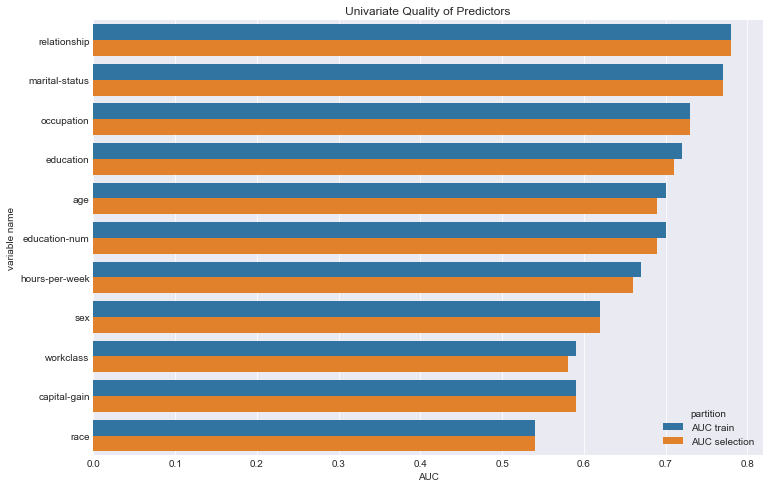

In [7]:
build.plotPredictorQuality(df_unisel)

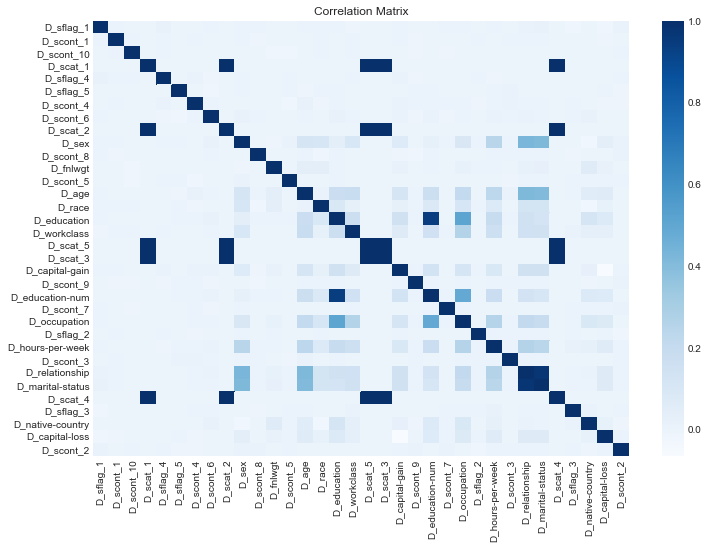

In [8]:
build.plotCorrMatrix(df_corr)

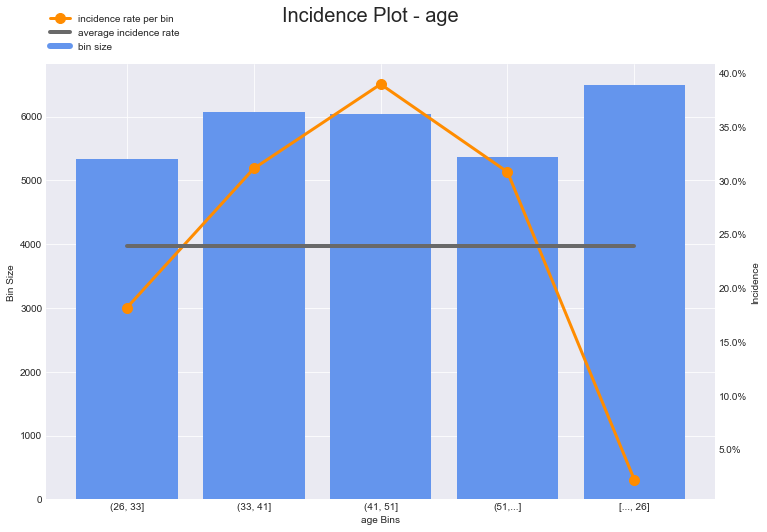

In [9]:
build.plotIncidence(df_transformed, 'age')

## <font color='blue'>Model building</font>
The next step is to find the best model. The library allows to build a model and specify which variables will be forced or excluded.

In [10]:
df_model1 = build.fit_model(df_transformed, 
                            df_unisel,
                            modeling_nsteps=30,
                            forced_vars=None,
                            excluded_vars=None,
                            name='All variables')

We can inspect what the output is. It contais all the necessary information about the model building:
  * model coefficients
  * predictors from forward selection
  * AUC performance on train/selection/validation set
  * cumulative response/gains
  * variable importance
  * etc.

In [11]:
df_model1.head(n=5)

,modelfit,predictor_names,predictor_lastadd,auc_train,auc_selection,auc_validation,pred_train,pred_selection,pred_validation,opt_var,cum_response,cum_gains,importance
1,"LogisticRegression(C=1000000000.0, class_weigh...",[D_relationship],D_relationship,0.780218,0.781627,0.772978,"[[0.450098205276], [0.474804415077], [0.474804...","[[0.450098205276], [0.450098205276], [0.450098...","[[0.450098205276], [0.450098205276], [0.450098...",False,"[52.38, 51.02, 50.0, 49.4, 46.79, 39.09, 33.63...","[0, 2.2, 4.28, 6.27, 8.27, 9.78, 9.81, 9.84, 9...",{'relationship': 1.0}
2,"LogisticRegression(C=1000000000.0, class_weigh...","[D_relationship, D_education]",D_education,0.859066,0.856856,0.856624,"[[0.656551644743], [0.340206121091], [0.340206...","[[0.35874766454], [0.35874766454], [0.45189692...","[[0.35874766454], [0.801812362972], [0.8018123...",False,"[83.67, 86.73, 83.41, 80.24, 80.22, 77.61, 76....","[0, 3.51, 7.27, 10.46, 13.43, 16.77, 19.48, 22...","{'relationship': 0.8, 'education': 0.63}"
3,"LogisticRegression(C=1000000000.0, class_weigh...","[D_relationship, D_education, D_capital-gain]",D_capital-gain,0.873490,0.872019,0.871225,"[[0.607037065649], [0.302668396598], [0.302668...","[[0.319120374668], [0.319120374668], [0.405787...","[[0.319120374668], [0.761797430597], [0.949579...",False,"[95.24, 93.2, 88.64, 87.56, 85.81, 83.18, 82.1...","[0, 3.99, 7.81, 11.12, 14.66, 17.94, 20.87, 24...","{'relationship': 0.76, 'education': 0.6, 'capi..."
4,"LogisticRegression(C=1000000000.0, class_weigh...","[D_relationship, D_education, D_capital-gain, ...",D_occupation,0.883831,0.881649,0.880897,"[[0.543633816582], [0.222680110411], [0.515592...","[[0.299823897743], [0.336215536958], [0.588679...","[[0.522139158402], [0.812382421662], [0.962570...",True,"[96.6, 94.22, 90.91, 89.61, 87.99, 85.45, 83.1...","[0, 4.05, 7.9, 11.41, 15.0, 18.39, 21.44, 24.3...","{'relationship': 0.73, 'education': 0.58, 'cap..."
5,"LogisticRegression(C=1000000000.0, class_weigh...","[D_relationship, D_education, D_capital-gain, ...",D_age,0.890825,0.889467,0.887605,"[[0.406637859747], [0.310922412191], [0.614605...","[[0.314276142254], [0.439506572877], [0.450037...","[[0.530181997148], [0.860439994521], [0.960120...",False,"[96.6, 95.24, 92.5, 91.14, 88.95, 86.14, 84.89...","[0, 4.05, 7.98, 11.61, 15.26, 18.59, 21.61, 24...","{'relationship': 0.72, 'education': 0.57, 'cap..."


Clearly, we again need visual inspection. Therefore, below are plots for **AUC**, **Variable importance** and **Cumulative gain/response**.

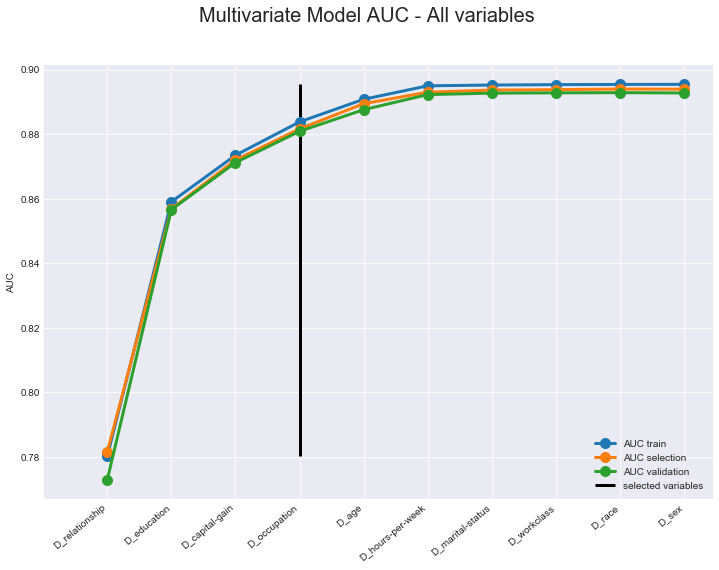

In [12]:
build.plotAUC(df_model1)

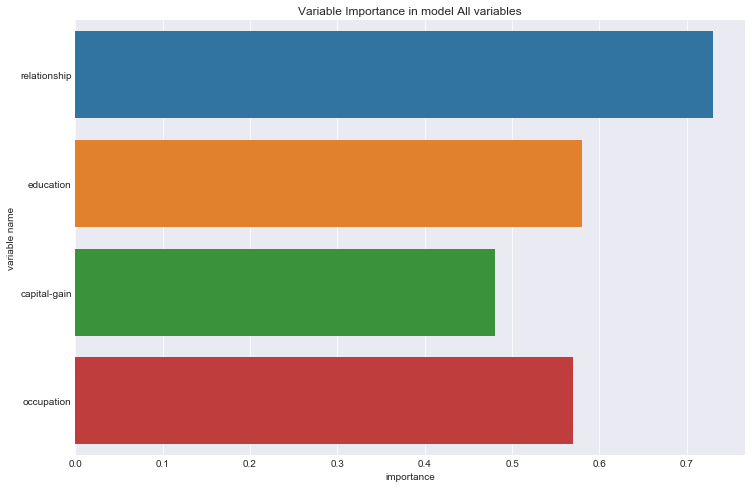

In [13]:
build.plotVariableImportance(df_model1)

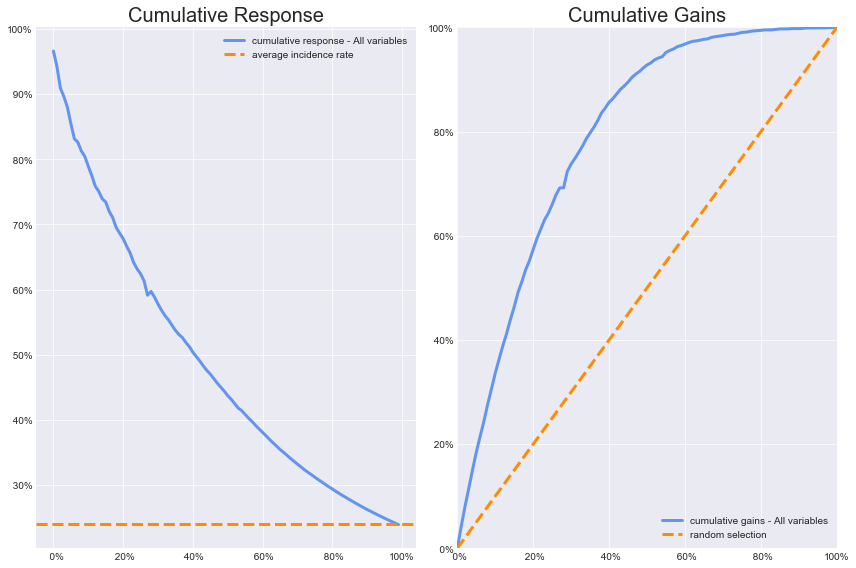

In [14]:
build.plotCumulatives([df_model1], df_transformed)

## <font color='blue'>Model comparison</font>
In the next step, the analyst needs to try different models. Thus, we can build multiple models and compare them. Below we build another two models and give them a name.

In [15]:
df_model2 = build.fit_model(df_transformed, 
                            df_unisel,
                            modeling_nsteps=30,
                            forced_vars=None,
                            excluded_vars=['age','relationship', 'sex'],
                            name='Experimental Model')

df_model3 = build.fit_model(df_transformed, 
                            df_unisel,
                            modeling_nsteps=5,
                            forced_vars=['capital-gain','hours-per-week'],
                            excluded_vars=['age','relationship', 'sex'],
                            name='Limited model')

And now we can compare all the three models as we are used to from the web version of COBRA - with **AUC comparison** and **Cumulative gains/response** plots.

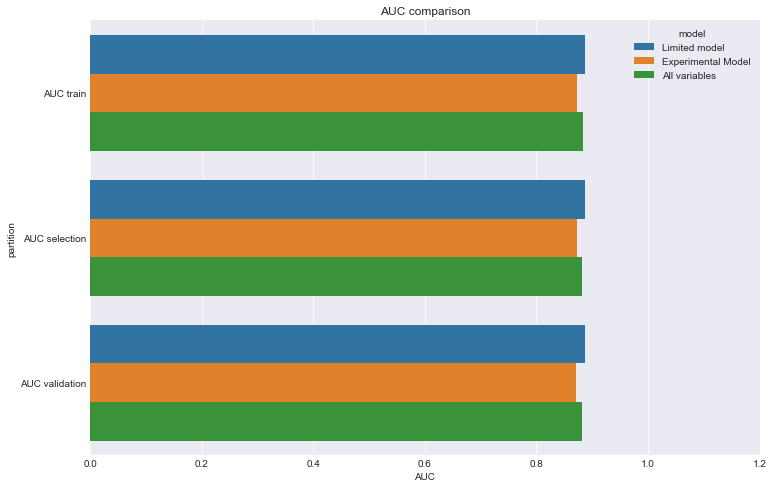

In [16]:
build.plotAUCComparison([df_model1, df_model2, df_model3])

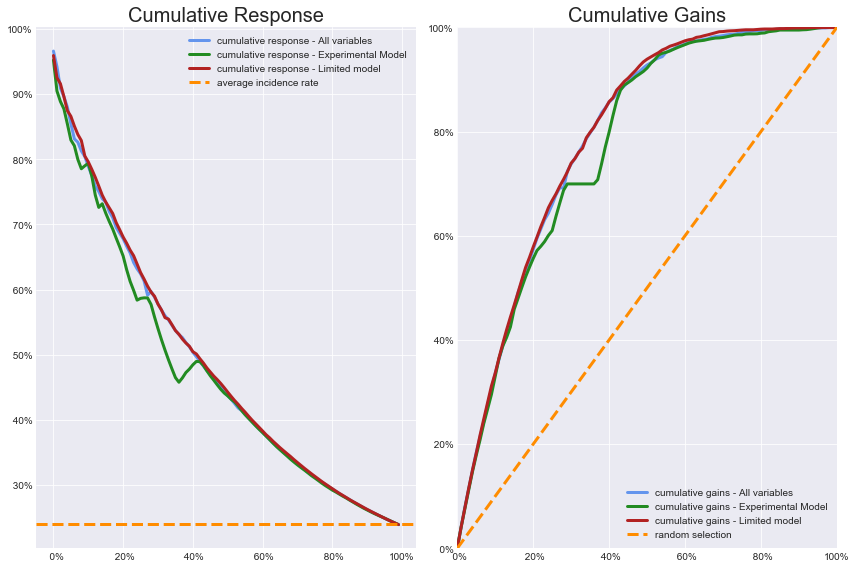

In [17]:
build.plotCumulatives([df_model1, df_model2, df_model3], df_transformed)